In [1]:
%pip install wget
%pip install pyarrow

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=462d12e551a9131b13759c31d6cd131d0c5c213892e6944afc02c4e36e97a4ca
  Stored in directory: /home/ubuntu/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
     |████████████████████████████████| 35.3 MB 4.3 MB/s eta 0:00:01


In [2]:
jan_2021="https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2021-01.parquet"
feb_2021="https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2021-02.parquet"
import wget
wget.download(jan_2021, "data/df_2021.parquet")
wget.download(feb_2021, "data/fhv_feb_2021.parquet")

'data/fhv_feb_2021.parquet'

In [33]:
import pandas as pd

df = pd.read_parquet('data/fhv_jan_2021.parquet')

In [34]:
df.shape

(1154112, 7)

In [35]:
df.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')

## get duration

In [36]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)

df['duration'] = df.dropOff_datetime - df.pickup_datetime
df['duration'] = df['duration'].apply(lambda x : x.total_seconds() / 60)

<AxesSubplot:>

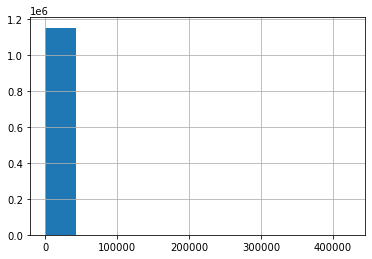

In [37]:
df['duration'].hist()

In [38]:
df['duration'].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

## Filter values

In [39]:
before_cnt = df.shape[0]
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
after_cnt = df.shape[0]

before_cnt - after_cnt

44286

## impute missing values

In [40]:
df.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration'],
      dtype='object')

In [41]:
df[['PUlocationID', 'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].fillna(-1)

In [42]:
len(df[df.PUlocationID == -1]) / len(df) * 100

83.52732770722618

## one hot encoding

In [43]:
cat = ['PUlocationID', 'DOlocationID']

df[cat] = df[cat].astype(str)

In [44]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()
train_dict = df[cat].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [45]:
len(dv.feature_names_)

525

## Train a model

In [46]:
target = 'duration'
y_train = df[target].values

In [47]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [48]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_pred, y_train, squared=False)

10.5285191072072

## Create validation dataset

In [49]:
cat = ['PUlocationID', 'DOlocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df['duration'].apply(lambda x : x.total_seconds() / 60)

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    df[cat] = df[cat].fillna(-1).astype(int).astype(str)

    return df

In [50]:
df_val = read_data('data/fhv_feb_2021.parquet')
df_val.shape

(990113, 8)

In [53]:
df_val.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration'],
      dtype='object')

In [58]:
val_dicts = df_val[cat].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val.duration.values

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

12.855086716472458